# PART 1 - Dataset creation

In [ ]:
# !pip install -q datasets
# !huggingface-cli login

In [ ]:
from datasets import load_dataset
import re

# Load the dataset
dataset = load_dataset('gretelai/synthetic_text_to_sql')

# Shuffle the dataset and slice it
dataset = dataset['train'].shuffle(seed=42).select(range(25000))
dataset = dataset.remove_columns(['domain', 'id', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description'])

# Define a function to transform the data
def transform_conversation(example):

    sql_prompt = example['sql_prompt']
    sql_context = example['sql_context']
    sql = example['sql']
    sql_explanation = example['sql_explanation']
    reformatted_segments = []

    # # Iterate over pairs of segments
    reformatted_segments.append(f'''<s>[INST] {sql_prompt}
                                Table info:
                                {sql_context} [/INST]

                                SQL solution:
                                {sql}
                                Explanation:
                                {sql_explanation} </s>''')

    return {'text': ''.join(reformatted_segments)}


# Apply the transformation
transformed_dataset = dataset.map(transform_conversation)
transformed_dataset = transformed_dataset.remove_columns(['sql_prompt', 'sql_context', 'sql', 'sql_explanation'])


In [5]:
# save the dataset
transformed_dataset.push_to_hub("text2sql-25k")

# check this out - https://huggingface.co/Rakshitgarg99/Llama-2-7b-text2sql-finetune

# PART 2 - Finetuning the llama2

In [ ]:
# Step 1: Install All the Required Packages
# !pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

In [ ]:
# Step 2: Import All the Required Libraries

import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [ ]:
# In case of Llama 2, the following prompt template is used for the chat models

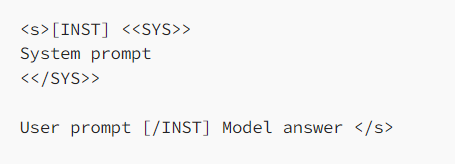

In [ ]:
# How to fine tune Llama 2
# - Free Google Colab offers a 15GB Graphics Card (Limited Resources --> Barely enough to store Llama 2–7b’s weights)
# - We also need to consider the overhead due to optimizer states, gradients, and forward activations
# - Full fine-tuning is not possible here: we need parameter-efficient fine-tuning (PEFT) techniques like LoRA or QLoRA.
# - To drastically reduce the VRAM usage, we must fine-tune the model in 4-bit precision, which is why we’ll use QLoRA here.

In [ ]:
# Step 3
# Load a llama-2-7b-chat-hf model (chat model)
# Train it on the mlabonne/guanaco-llama2-1k (1,000 samples), which will produce our fine-tuned model Llama-2-7b-chat-finetune
# QLoRA will use a rank of 64 with a scaling parameter of 16. We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type and train it for one epoch

In [ ]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"

# The instruction dataset to use
dataset_name = "Rakshitgarg99/text2sql-25k"

# Fine-tuned model name
new_model = "Llama2_finetuned"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-2

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [ ]:
# Step 4:Load everything and start the fine-tuning process
# 1. First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt,
# filter out bad text, combine multiple datasets, etc.

# 2. Then, we’re configuring bitsandbytes for 4-bit quantization.
# 3. Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.
# 4. Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!


# IMPORTANT

- 2000 examples usually takes 30-35 mins.
- For 20k it takes 4.5 Hrs will advice to use paid resource as colab will disconnect

In [ ]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train")

# Select only the first 2000 examples
dataset = dataset.select(range(2000))


# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

In [ ]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

In [ ]:
# Save trained model
trainer.model.save_pretrained(new_model)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/My Drive/models/'
new_model_path = os.path.join(drive_path, new_model)

# Ensure the directory exists
os.makedirs(new_model_path, exist_ok=True)

# Save the trained model to Google Drive
trainer.model.save_pretrained(new_model_path)

print(f"Model saved to {new_model_path}")

In [ ]:
# Step 5: Check the plots on tensorboard, as follows

%load_ext tensorboard
%tensorboard --logdir results/runs

In [ ]:
# Step 6:Use the text generation pipeline to ask questions.

# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = '''
How many species are recorded in the 'biodiversity' table?
Table info: CREATE TABLE biodiversity (id INT, species VARCHAR(255), population INT); INSERT INTO biodiversity (id, species, population) VALUES (1, 'Polar Bear', 5000), (2, 'Arctic Fox', 10000), (3, 'Caribou', 20000);
'''
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])




In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

# IMPORTANT

- Restart the session as colab will exceeds its memory limits in merging of weights

In [ ]:
# Step 7: Store New Llama2 Model (Llama-2-7b-chat-finetune)

# How can we store our new Llama-2-7b-chat-finetune model now? We need to merge the weights from LoRA with the base model.
# Unfortunately, as far as I know, there is no straightforward way to do it: we need to reload the base model in FP16 precision
# and use the peft library to merge everything.
# Reload model in FP16 and merge it with LoRA weights

lora_weights = "/content/drive/My Drive/models/"

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, lora_weights)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"



In [ ]:
# Step 8: Push Model to Hugging Face Hub
# Our weights are merged and we reloaded the tokenizer. We can now push everything to the Hugging Face Hub to save our model.

import locale
locale.getpreferredencoding = lambda: "UTF-8"

!huggingface-cli login

model.push_to_hub("Rakshitgarg99/Llama-2-7b-text2sql-finetune", check_pr=True)
tokenizer.push_to_hub("Rakshitgarg99/Llama-2-7b-text2sql-finetune",check_pr=True)



# PART 3 - Running the model with gardio interface

In [1]:
# !pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7
# !pip install gradio

import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Load the entire model on the GPU 0
device_map = {"": 0} # use -1 for cpu


# model_name = "NousResearch/Llama-2-7b-chat-hf" # base model
model_name = "Rakshitgarg99/Llama-2-7b-text2sql-finetune"

new_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [5]:
prompt = '''
What is the sum of transaction amounts for clients living in Texas? Table info: CREATE TABLE clients (id INT, name TEXT, age INT, state TEXT, transaction_amount DECIMAL(10,2)); INSERT INTO clients (id, name, age, state, transaction_amount) VALUES (1, 'Juan Hernandez', 35, 'Texas', 120.00); INSERT INTO clients (id, name, age, state, transaction_amount) VALUES (2, 'Maria Lopez', 40, 'Texas', 180.50); INSERT INTO clients (id, name, age, state, transaction_amount) VALUES (3, 'Carlos Martinez', 45, 'Texas', 250.00);'''

pipe = pipeline(task="text-generation", model=new_model, tokenizer=tokenizer, max_length=500)
result = pipe(f"<s>[INST] {prompt} [/INST]")
    # print(result[0]['generated_text'])
print(result[0]['generated_text'])



<s>[INST] 
What is the sum of transaction amounts for clients living in Texas? Table info: CREATE TABLE clients (id INT, name TEXT, age INT, state TEXT, transaction_amount DECIMAL(10,2)); INSERT INTO clients (id, name, age, state, transaction_amount) VALUES (1, 'Juan Hernandez', 35, 'Texas', 120.00); INSERT INTO clients (id, name, age, state, transaction_amount) VALUES (2, 'Maria Lopez', 40, 'Texas', 180.50); INSERT INTO clients (id, name, age, state, transaction_amount) VALUES (3, 'Carlos Martinez', 45, 'Texas', 250.00); [/INST]

SQL solution:
SELECT SUM(transaction_amount) FROM clients WHERE state = 'Texas'; 
Explanation: 
This query calculates the sum of transaction amounts for clients living in Texas. It does this by using the SUM function on the transaction_amount column, and filtering the results to only include rows where the state is 'Texas'. The SUM function calculates the sum of the values in the transaction_amount column for each row that meets the filter criteria. The WHERE

In [14]:
print(result[0]['generated_text'].split("[/INST]")[1].strip())

SQL solution:
SELECT SUM(transaction_amount) FROM clients WHERE state = 'Texas'; 
Explanation: 
This query calculates the sum of transaction amounts for clients living in Texas. It does this by using the SUM function on the transaction_amount column, and filtering the results to only include rows where the state is 'Texas'. The SUM function calculates the sum of the values in the transaction_amount column for each row that meets the filter criteria. The WHERE clause filters the results to only include rows where the state is 'Texas'. The result is the sum of transaction amounts for clients living in Texas.


In [4]:
import gradio as gr

# Define the function that generates the blog response
def generate_blog(input_text):


    pipe = pipeline(task="text-generation", model=new_model, tokenizer=tokenizer, max_length=500)
    result = pipe(f"<s>[INST] {input_text} [/INST]")
    # print(result[0]['generated_text'])
    return result[0]['generated_text'].split("[/INST]")[1].strip()

# Create inputs using Gradio components
input_text = gr.Textbox(label="Enter the SQL question info")

# Create the Gradio interface
iface = gr.Interface(
    fn=generate_blog,
    inputs=[input_text],
    outputs="text",
    title="Generate Text TO SQL 🤖",
    description="Generate SQL queries based on the Textual Information.",
    theme="compact",
)

# Launch the Gradio interface in the notebook
iface.launch()


/usr/local/lib/python3.10/dist-packages/gradio/blocks.py:953: UserWarning: Cannot load compact. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/compact (Request ID: Root=1-6692ada3-7e8935b344c5a2673f63417d;c6ecf10d-39b6-4917-a40b-bb2a5c5f0916)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://49528f7267c4ec201d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
